In [1]:
# import the necessary packages
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [2]:
def build_siamese_model(inputShape, embeddingDim=48):
    # specify the inputs for the feature extractor network
    inputs = Input(inputShape)
    # define the first set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)
    # second set of CONV => RELU => POOL => DROPOUT layers
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    # prepare the final outputs
    pooledOutput = GlobalAveragePooling2D()(x)
    outputs = Dense(embeddingDim)(pooledOutput)
    # build the model
    model = Model(inputs, outputs)
    # return the model to the calling function
    return model

In [3]:
# import the necessary packages
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def make_pairs(images, labels):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive or negative
    pairImages = []
    pairLabels = []
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    numClasses = len(np.unique(labels))
    idx = [np.where(labels == i)[0] for i in range(0, numClasses)]
    # loop over all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current
        # iteration
        currentImage = images[idxA]
        label = labels[idxA]
        # randomly pick an image that belongs to the *same* class
        # label
        idxB = np.random.choice(idx[label])
        posImage = images[idxB]
        # prepare a positive pair and update the images and labels
        # lists, respectively
        pairImages.append([currentImage, posImage])
        pairLabels.append([1])
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negIdx = np.where(labels != label)[0]
        negImage = images[np.random.choice(negIdx)]
        # prepare a negative pair of images and update our lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([0])
    # return a 2-tuple of our image pairs and labels
    return (np.array(pairImages), np.array(pairLabels))

In [5]:
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [6]:
def plot_training(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.plot(H.history["accuracy"], label="train_acc")
    plt.plot(H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    #plt.savefig(plotPath)

In [7]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [8]:
from PIL import Image
base_dir = r'D:\downloade2\dd\oneshot_data\fruits-360\data'
#train_test_split = 0.7
no_of_files_in_each_class = 5

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape) 

# testing data 
cat_test_list = []
x_test = []
y_test = []
y_test_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp_test=[]
    for file_name in files_list[no_of_files_in_each_class:no_of_files_in_each_class+2]:
        temp_test.append(len(x_test))
        x_test.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y_test.append(y_test_label)
    y_test_label+=1
    cat_test_list.append(temp_test)

cat_test_list = np.asarray(cat_test_list)
x_test = np.asarray(x_test)/255.0
y_test = np.asarray(y_test)
print('X test, Y test shape',x_test.shape, y_test.shape, cat_test_list.shape) 

6 categories found in the dataset
X, Y shape (30, 100, 100, 3) (30,) (6, 5)
X test, Y test shape (12, 100, 100, 3) (12,) (6, 2)


In [9]:
print("[INFO] preparing positive and negative pairs...")
(pairTrain, labelTrain) = make_pairs(x, y)
(pairTest, labelTest) = make_pairs(x_test, y_test)

[INFO] preparing positive and negative pairs...


In [10]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=(100,100,3))
imgB = Input(shape=(100,100,3))
featureExtractor = build_siamese_model((100,100,3))
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

[INFO] building siamese network...


In [11]:
# finally, construct the siamese network
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [12]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
    [pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
    validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
    batch_size=2, 
    epochs=10)

[INFO] compiling model...
[INFO] training model...
Epoch 1/10
30/30 [==============================] - 6s 153ms/step - loss: 0.6471 - accuracy: 0.5631 - val_loss: 0.5588 - val_accuracy: 0.7917
Epoch 2/10
30/30 [==============================] - 3s 96ms/step - loss: 0.6345 - accuracy: 0.4547 - val_loss: 0.5294 - val_accuracy: 0.8750
Epoch 3/10
30/30 [==============================] - 3s 99ms/step - loss: 0.5345 - accuracy: 0.6011 - val_loss: 0.4924 - val_accuracy: 0.8750
Epoch 4/10
30/30 [==============================] - 3s 96ms/step - loss: 0.5397 - accuracy: 0.5435 - val_loss: 0.4594 - val_accuracy: 0.8750
Epoch 5/10
30/30 [==============================] - 3s 95ms/step - loss: 0.4665 - accuracy: 0.5465 - val_loss: 0.4181 - val_accuracy: 0.8750
Epoch 6/10
30/30 [==============================] - 3s 107ms/step - loss: 0.4208 - accuracy: 0.5953 - val_loss: 0.4083 - val_accuracy: 0.9583
Epoch 7/10
30/30 [==============================] - 3s 101ms/step - loss: 0.4292 - accuracy: 0.7017 -

[INFO] plotting training history...


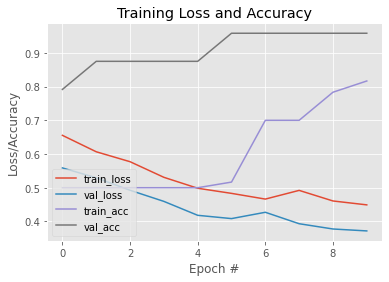

In [13]:
# plot the training history
print("[INFO] plotting training history...")
plot_training(history)

In [14]:
imageA = x[0]
imageB = x[11]

#create a copy of both the images for visualization purpose
origA = imageA.copy()
origB = imageB.copy()
# add channel a dimension to both the images
#imageA = np.expand_dims(imageA, axis=-1)
#imageB = np.expand_dims(imageB, axis=-1)
# add a batch dimension to both images
imageA = np.expand_dims(imageA, axis=0)
imageB = np.expand_dims(imageB, axis=0)
# scale the pixel values to the range of [0, 1]
imageA = imageA 
imageB = imageB 

# use our siamese model to make predictions on the image pair,
# indicating whether or not the images belong to the same class
preds = model.predict([imageA, imageB])
proba=preds[0][0]


In [15]:
imageA.shape

(1, 100, 100, 3)

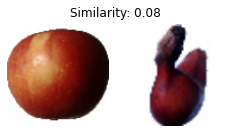

In [16]:
# initialize the figure
fig = plt.figure(figsize=(4, 2))
plt.suptitle("Similarity: {:.2f}".format(proba))
# show first image
ax = fig.add_subplot(1, 2, 1)
plt.imshow(origA, cmap=plt.cm.gray)
plt.axis("off")
# show the second image
ax = fig.add_subplot(1, 2, 2)
plt.imshow(origB, cmap=plt.cm.gray)
plt.axis("off")
# show the plot
plt.show()

(100, 100, 3)

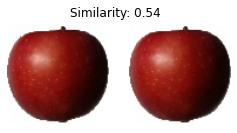

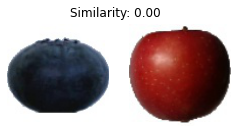

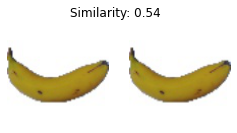

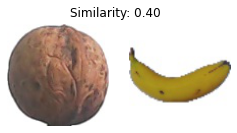

IndexError: index 13 is out of bounds for axis 0 with size 12

In [17]:
import random
for i in range(100):
    idx= random.randint(i,i+10)
    imageA = x_test[idx]
    imageB = x_test[i]
#create a copy of both the images for visualization purpose
    origA = imageA.copy()
    origB = imageB.copy()
# add channel a dimension to both the images
#imageA = np.expand_dims(imageA, axis=-1)
#imageB = np.expand_dims(imageB, axis=-1)
# add a batch dimension to both images
    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)
# scale the pixel values to the range of [0, 1]
    imageA = imageA 
    imageB = imageB 
# use our siamese model to make predictions on the image pair,
# indicating whether or not the images belong to the same class
    preds = model.predict([imageA, imageB])
    proba=preds[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(origA)
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(origB)
    plt.axis("off")
    # show the plot
    plt.show()

In [98]:
# # # resize image 
# test_image_1 = Image.open('C:/Users/Mahendra/Downloads/defective_potato.jpg')
# test_image_2 = Image.open('C:/Users/Mahendra/Downloads/defective2.jpg')
# test_image1 = test_image_1.resize((100,100))
# test_image2 = test_image_2.resize((100,100))
# test_image1.save('C:/Users/Mahendra/Downloads/Defective_test_1.jpg')
# test_image2.save('C:/Users/Mahendra/Downloads/Defective_test_2.jpg')

In [100]:
import glob
cv_img = []
for img in glob.glob("C:/Users/Mahendra/Downloads/*.jpg"):
    n= cv2.imread(img)
    cv_img.append(n)

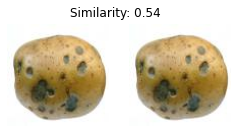

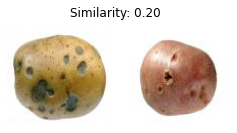

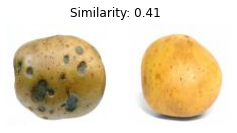

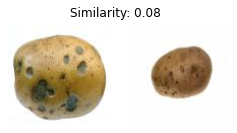

In [107]:
for i in range(len(cv_img)):
    
    img_1=cv_img[0]
    img_2 = cv_img[i]
    origA=img_1.copy()
    origB = img_2.copy()
    img_1=img_1/255
    img_2=img_2/255
    imageA = np.expand_dims(img_1, axis=0)
    imageB = np.expand_dims(img_2, axis=0)
    preds = model.predict([imageA, imageB])
    proba=preds[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(origA,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(origB,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the plot

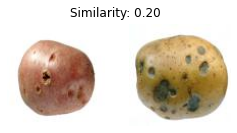

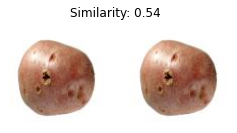

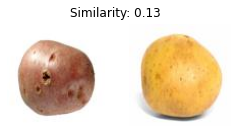

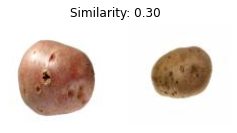

In [108]:
for i in range(len(cv_img)):
    
    img_1=cv_img[1]
    img_2 = cv_img[i]
    origA=img_1.copy()
    origB = img_2.copy()
    img_1=img_1/255
    img_2=img_2/255
    imageA = np.expand_dims(img_1, axis=0)
    imageB = np.expand_dims(img_2, axis=0)
    preds = model.predict([imageA, imageB])
    proba=preds[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(origA,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(origB,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the plot

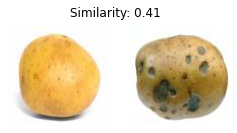

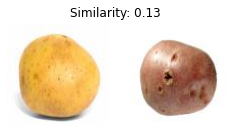

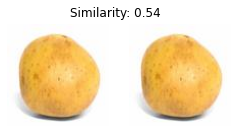

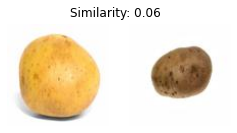

In [109]:
for i in range(len(cv_img)):
    
    img_1=cv_img[2]
    img_2 = cv_img[i]
    origA=img_1.copy()
    origB = img_2.copy()
    img_1=img_1/255
    img_2=img_2/255
    imageA = np.expand_dims(img_1, axis=0)
    imageB = np.expand_dims(img_2, axis=0)
    preds = model.predict([imageA, imageB])
    proba=preds[0][0]
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 2))
    plt.suptitle("Similarity: {:.2f}".format(proba))
    # show first image
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(origA,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the second image
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(origB,cv2.COLOR_BGR2RGB))
    plt.axis("off")
    # show the plot